In [1]:
# pip install segmentation-models

__To solve segmentation-model error:__
    
1. Go to `"./../anaconda3/Lib/site-packages/efficientnet/__init__.py"`
2. In the file change `keras.utils.generic_utils.get_custom_objects().update(custom_objects)` to `keras.utils.get_custom_objects().update(custom_objects)`

In [1]:
import sys
import tensorflow as tf
import keras
import osgeo
import segmentation_models as sm

2024-03-03 17:18:40.336583: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-03-03 17:18:40.357980: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 17:18:40.357995: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 17:18:40.358691: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-03 17:18:40.362076: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `keras` framework.


In [2]:
print(sys.version)
print(tf.__version__)
print(keras.__version__)
print(osgeo.__version__)
print(sm.__version__)

3.11.7 (main, Dec 15 2023, 18:12:31) [GCC 11.2.0]
2.15.0
2.15.0
3.6.2
1.0.1


Dataset:  https://zenodo.org/records/5914759

In [3]:
import os
import random
from tqdm import tqdm
import numpy as np
import pandas as pd
from osgeo import gdal
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Conv2DTranspose, concatenate, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from keras.callbacks import ModelCheckpoint
from keras.utils import to_categorical
from keras.metrics import MeanIoU

## 1.


 image : width, height, No_of_bands : (1364, 1295, 4)

 ground truth : width, height, No_of_bands : (1364, 1295, 3)


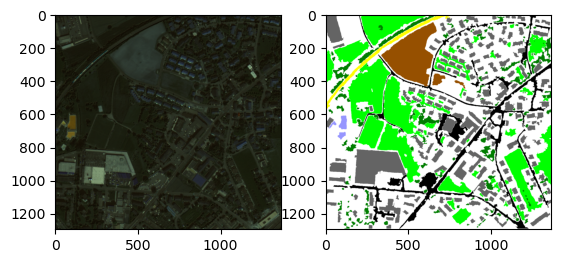

In [4]:
# dataset folder
data_dir = "./Zurich_dataset_v1.0/"
images_dir = data_dir + "images_tif/"
groundtruth_dir = data_dir + "groundtruth/"

# Load the single image and ground truth mask for plotting
image_id = 1
image_path = images_dir + f"zh{image_id}.tif"
mask_path = groundtruth_dir + f"zh{image_id}_GT.tif"

def load_and_plot(file_path):
    file = gdal.Open(file_path)
    print(f"width, height, No_of_bands : ({file.RasterXSize}, {file.RasterYSize}, {file.RasterCount})")

    #read all three band information
    band_list = []
    start_band = 1 # band starts from indeex 1 not 0
    end_band = file.RasterCount
    for i in range(start_band,end_band+1): 
        #read each band information
        Fband = file.GetRasterBand(i) 
        #Read each band data to a 2D array
        Fdata = Fband.ReadAsArray()
        band_list.append(Fdata)

    band_array = np.array(band_list)
    band_array = band_array.transpose(1,2,0)
    
    return band_array

# image
print('\n image : ', end = "")
img_array = load_and_plot(image_path)

# Normalize the bands
scaler = MinMaxScaler()
img_array = scaler.fit_transform(img_array.reshape(-1, img_array.shape[-1])).reshape(img_array.shape)
img_array = img_array[:,:,:3] # Band 1,2,3 are R-G-B

# ground truth
print('\n ground truth : ', end = "")
mask_array = load_and_plot(mask_path)

# Plot for image
plt.subplot(1, 2, 1)
plt.imshow(img_array)

# Plot for ground truth
plt.subplot(1, 2, 2)
plt.imshow(mask_array)

plt.show()

In [5]:
def load_data(images_dir:str, groundtruth_dir:str, image_range: list):
    images = []
    masks = []

    for image_id in range(image_range[0], image_range[1]+1):
        # Load image
        img_path = images_dir + f"zh{image_id}.tif"
        image_data = gdal.Open(img_path)
        img = image_data.ReadAsArray()  # shape (channels, X, Y)
        img = img.transpose(1,2,0) # shape (X, Y, channels)
        
        # scale img to 0-1 range; normalizing each channels independently
        scaler = MinMaxScaler()
        num_channels = img.shape[-1]
        img = scaler.fit_transform(img.reshape(-1, num_channels)).reshape(img.shape) # each column represent a band
        
        
        # Load mask
        mask_path = groundtruth_dir + f"zh{image_id}_GT.tif"
        mask_data = gdal.Open(mask_path)
        mask = mask_data.ReadAsArray()  # shape (channels, X, Y)
        mask = mask.transpose(1,2,0) # shape (X, Y, channels)

        images.append(img[:,:,:3]) # RGB band only
        masks.append(mask)
        
    print(f"Images count: {len(images)} & Masks count: {len(masks)}")
    print('Images are Normalized and Masks are not !')

    print()
    print('Each Image & its corresponding mask size : ')
    # to get the shape of all images and masks
    for i,m in zip(images, masks):
        print(i.shape, m.shape)

    print()
        
    return images, masks

Images count: 5 & Masks count: 5
Images are Normalized and Masks are not !

Each Image & its corresponding mask size : 
(1295, 1364, 3) (1295, 1364, 3)
(833, 881, 3) (833, 881, 3)
(926, 943, 3) (926, 943, 3)
(1001, 1068, 3) (1001, 1068, 3)
(1107, 1182, 3) (1107, 1182, 3)



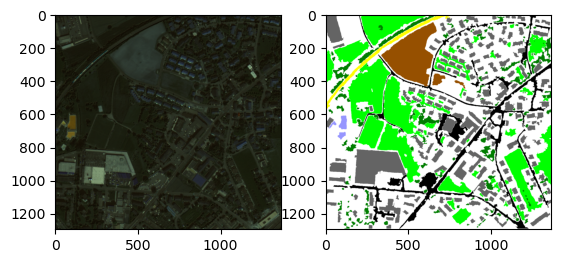

In [6]:
# train set
train_images, train_masks = load_data(images_dir, groundtruth_dir, [1,5]) # 1-5 for training

# Plot image
plt.subplot(1, 2, 1)
plt.imshow(train_images[0][:,:,:3]) # RGB 1st image

# Plot for ground truth
plt.subplot(1, 2, 2)
plt.imshow(train_masks[0])

plt.show()

Images count: 5 & Masks count: 5
Images are Normalized and Masks are not !

Each Image & its corresponding mask size : 
(1146, 872, 3) (1146, 872, 3)
(1025, 1112, 3) (1025, 1112, 3)
(748, 800, 3) (748, 800, 3)
(729, 1223, 3) (729, 1223, 3)
(1066, 1491, 3) (1066, 1491, 3)



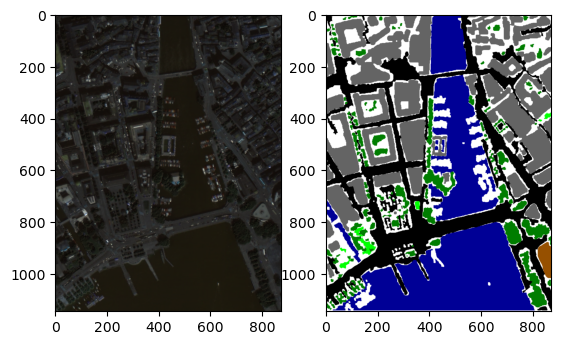

In [7]:
# test set
test_images, test_masks = load_data(images_dir, groundtruth_dir, [16,20]) # 16-20 for testing
# Plot a image
plt.subplot(1, 2, 1)
plt.imshow(test_images[0][:,:,:3]) # RGB

# Plot for ground truth
plt.subplot(1, 2, 2)
plt.imshow(test_masks[0])

plt.show()

Each image has different size. And also because of computational limit, I will get patches of shape (224,224) as I will use keras pre-trained cnn model.

Now in prepocessing: We have to normalize each image independently to other image. And for each image also we have to normalize each band independent to other band in that image. Normalize in range [0-1]
    
Before creating patch we have to do pre-processing as if we do after patch creation it will be independent, but from a image patches are created. so before patch.

In [9]:
# patches extraction

# creating overlap patches and which makes train data larger
def extract_patches(images:list, masks:list, patch_size=(224, 224), stride=1): 
    image_patches = []
    mask_patches = []

    for i in tqdm(range(len(images))):
        img = images[i]
        mask = masks[i]
        height, width, _ = img.shape

        for y in range(0, height - patch_size[0] + 1, stride):
            for x in range(0, width - patch_size[1] + 1, stride):
                image_patch = img[y:y + patch_size[0], x:x + patch_size[1], :]
                mask_patch = mask[y:y + patch_size[0], x:x + patch_size[1], :]

                image_patches.append(image_patch)
                mask_patches.append(mask_patch)

    return np.array(image_patches), np.array(mask_patches)

# train set:
patch_size = (224, 224)
stride = 80
train_image_patches, train_mask_patches = extract_patches(train_images, train_masks, patch_size, stride)
print("Image patches shape:", train_image_patches.shape)
print("Mask patches shape:", train_mask_patches.shape) 

100%|██████████████████████████████████████████| 5/5 [00:00<00:00, 15673.78it/s]


Image patches shape: (617, 224, 224, 3)
Mask patches shape: (617, 224, 224, 3)


In [10]:
train_image_patches.max(), train_image_patches.min()

(1.0000000000000002, 0.0)

In [11]:
train_mask_patches.max(), train_mask_patches.min()

(255, 0)

In [12]:
# To find unique values of each all pixels in all images
unique_values = np.unique(train_mask_patches.reshape(-1, 3), axis=0) # Reshape to 2D array;  find the unique rows (unique pixel values) - a pixel with 3 channels
print(len(unique_values))
print(unique_values)

9
[[  0   0   0]
 [  0   0 150]
 [  0 125   0]
 [  0 255   0]
 [100 100 100]
 [150  80   0]
 [150 150 255]
 [255 255   0]
 [255 255 255]]


In [15]:
def rgb_to_label(image_mask):
    """
    Convert 3D- RGB label masks to 2D label masks.
    """
    # all 8 (Roads, Buildings, Trees, Grass, Bare Soil, Water, Railways and Swimming pools) classes and background/unlabelled
    # below is the RGB to integer label
    C0 = np.array([0,0,0])
    trees = np.array([0, 125, 0])   # RGB values for Trees
    grass = np.array([0, 255, 0])   # RGB values for Grass
    C1 = np.array([0, 0, 150])
    C4 = np.array([100, 100, 100])   
    C5 = np.array([150, 80, 0])   
    C6 = np.array([150, 150, 255])   
    C7 = np.array([255, 255, 0])  
    C8 = np.array([255, 255, 255])
    
    # We are interested in correctly identifying two classes - trees and grass
    # So, make all classes except these 2 as same class label with 0 label
    label_seg = np.zeros(image_mask.shape[:2], dtype=np.uint8)
    label_seg[np.all(image_mask == C0, axis=-1)] = 0
    label_seg[np.all(image_mask == trees, axis=-1)] = 1
    label_seg[np.all(image_mask == grass, axis=-1)] = 2
    label_seg[np.all(image_mask == C1, axis=-1)] = 0
    label_seg[np.all(image_mask == C4, axis=-1)] = 0
    label_seg[np.all(image_mask == C5, axis=-1)] = 0
    label_seg[np.all(image_mask == C6, axis=-1)] = 0
    label_seg[np.all(image_mask == C7, axis=-1)] = 0
    label_seg[np.all(image_mask == C8, axis=-1)] = 0
    
    return label_seg

In [8]:
def label_to_rgb(label_mask):
    """
    Convert 2D label masks back to RGB masks.
    """
    # RGB values corresponding to each class label
    colors = {
        0: [0, 0, 0],      # other classes
        1: [0, 125, 0],    # Class 1 (Trees)
        2: [0, 255, 0]    # Class 2 (Grass)
    }

    num_channels = len(colors[0])
    # an empty RGB image mask
    rgb_mask = np.zeros((label_mask.shape[0], label_mask.shape[1], num_channels), dtype=np.uint8)

    # Map class labels to RGB values
    for label, color in colors.items():
        rgb_mask[label_mask == label] = color

    return rgb_mask

In [15]:
# Train labels
train_labels = []
for i in tqdm(range(train_mask_patches.shape[0])):
    label = rgb_to_label(train_mask_patches[i])
    train_labels.append(label)
    
train_labels = np.array(train_labels)
print(train_labels.shape)
print('Total unique classes : ', len(np.unique(train_labels)))
print('Class Labels : ', np.unique(train_labels))

100%|████████████████████████████████████████| 617/617 [00:03<00:00, 193.99it/s]


(617, 224, 224)
Total unique classes :  3
Class Labels :  [0 1 2]


In [16]:
train_labels = np.expand_dims(train_labels, axis=3)
print(train_labels.shape)

(617, 224, 224, 1)


In [17]:
n_classes = len(np.unique(train_labels))
train_labels_cat = to_categorical(train_labels, num_classes=n_classes) # this gives one-hot in order refer to documentation
# Note: The input labels has to be in number form and value from 0 to num_class-1.
print(train_labels_cat.shape)

(617, 224, 224, 3)


In [18]:
#Class weights claculation for Dice loss 
# inverse class frequency: A class with fewer pixels will have a higher inverse frequency. normalize them so that they sum up to 1
# unique elements and their counts
unique_elements, counts = np.unique(train_labels, return_counts=True)
# inverse class frequency
inverse_frequencies = dict(zip(unique_elements, sum(counts)/counts))
inverse_frequencies
# Normalize inverse frequencies to sum up to 1
total_inverse_frequency = sum(inverse_frequencies.values())
class_weights = {cls: round(freq/total_inverse_frequency, 2) for cls, freq in inverse_frequencies.items()}
class_weights

{0: 0.05, 1: 0.55, 2: 0.41}

In [19]:
def model_train_pipeline(X_train, y_train, BACKBONE = 'resnet34', epochs = 100):
    preprocess_input = sm.get_preprocessing(BACKBONE)

    # preprocess input
    X_train = preprocess_input(X_train)
    print(X_train.shape, y_train.shape)
    
    IMG_HEIGHT = X_train.shape[1]
    IMG_WIDTH  = X_train.shape[2]
    IMG_CHANNELS = X_train.shape[3]

    n_classes = y_train.shape[3]

    # define model;  encoder_freeze=False i.e training Encoder with imagenet as initial weights o/w Fine tuning if True 
    base_model = sm.Unet(BACKBONE, encoder_weights='imagenet', classes= n_classes, activation='softmax',
                   encoder_freeze=False, decoder_filters=(256, 128, 64, 32, 16), decoder_use_batchnorm=True)

    inp = Input(shape=(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    l1 = Conv2D(3, (1, 1))(inp) # map N channels data to 3 channels
    out = base_model(l1)

    model = Model(inp, out, name=base_model.name)

    # based on this i have manually put the class weightage which sums to one; i can also take from the above one
    class_weights = [0.1,0.5,0.4] # If some class has a weight of 0.00, it means that the model will not consider that class during the calculation of the loss function.
    
    #Define loss, metrics and optimizer to be used for training
    dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
    focal_loss = sm.losses.CategoricalFocalLoss()
    total_loss = dice_loss + (1 * focal_loss)  
    
    metrics = ['accuracy', sm.metrics.IOUScore(class_weights=class_weights)]
    
    lr = 0.0001
    optim = keras.optimizers.Adam(lr)

    model.compile(optimizer=optim, loss= total_loss, metrics=metrics)
    
    
    model_checkpoint_folder = './model_checkpoint/'
    os.makedirs(model_checkpoint_folder, exist_ok = True)

    filename = f'zurich_train_{BACKBONE}.hdf5'
    print('Model will be saved in directory : ', model_checkpoint_folder)
    fname = os.path.join(model_checkpoint_folder, filename)

    # Set callback functions to early stop training and save the best model so far; `iou_score` is the above defined metric name
    callbacks = [ModelCheckpoint(filepath = fname, monitor = 'iou_score', mode='max', save_best_only = True, verbose = 1)]#,lrate_scheduler                         


    history = model.fit(X_train, y_train, 
                        batch_size = 16,
                        validation_split=0.10,
                        verbose=1, 
                        epochs=epochs, 
                        shuffle=True,
                       callbacks = callbacks)

    return fname, history

In [20]:
def acc_loss_plot(history):
    # Set the size of the figure
    plt.figure(figsize=(12, 4)) 

    # Plot training and validation loss
    plt.subplot(1, 2, 1)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)
    plt.plot(epochs, loss, 'y', label='Training loss')
    plt.plot(epochs, val_loss, 'r', label='Validation loss')
    plt.title('Training and validation loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Plot training and validation IoU
    plt.subplot(1, 2, 2)
    acc = history.history['iou_score']
    val_acc = history.history['val_iou_score']
    plt.plot(epochs, acc, 'y', label='Training IoU')
    plt.plot(epochs, val_acc, 'r', label='Validation IoU')
    plt.title('Training and validation IoU')
    plt.xlabel('Epochs')
    plt.ylabel('IoU')
    plt.legend()

    plt.show()

In [21]:
def test_prediction(model, images:list, patch_size=(224, 224), BACKBONE = None): 
    pred_labels = []

    if BACKBONE:
        preprocess_input = sm.get_preprocessing(BACKBONE)
    
    for i in tqdm(range(len(images))):
        img = images[i] # each image is of size (height, width, channels)
        label_seg = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        height, width, _ = img.shape
        
        if height % patch_size[0] == 0: # say height = 448 and patch_size = (224,224)
            height_pixels = [i for i in range(0, height - patch_size[0] + 1, patch_size[0])] # then = [0, 224]

        else: # say height = 449
            height_pixels = [i for i in range(0, height + 1, patch_size[0])] # then = [0, 224, 448]


        if width % patch_size[1] == 0: # slly
            width_pixels = [i for i in range(0, width - patch_size[1] + 1, patch_size[1])]

        else: # say height = 449
            width_pixels = [i for i in range(0, width + 1, patch_size[1])]
            

        for y in height_pixels:
            for x in width_pixels:
                x1 = x
                y1 = y

                y2 = y1 + patch_size[0]
                x2 = x1 + patch_size[1]

                if width % patch_size[1] != 0 and x == width_pixels[-1]: # if not multiple of patch size & x is the last element
                    # then take patch from last-patch_size to last pixel
                    x1 = width - patch_size[1]
                    x2 = width

                    width_rem = width - x # difference between last pixel in image and last element in width_pixels

                if height % patch_size[0] != 0 and y == height_pixels[-1]: # if not multiple of patch size& y is the last element
                    # then take patch from last-patch_size to last pixel
                    y1 = height - patch_size[0]
                    y2 = height

                    height_rem = height - y # slly


                image_patch = img[y1:y2, x1:x2, :]

                image_patch = np.expand_dims(image_patch, 0) # to shape (1, height, width, channels)

                # preprocess input
                if BACKBONE:
                    image_patch = preprocess_input(image_patch)

                y_pred = model.predict(image_patch, verbose=0)  # shape (1, height, width, num_classes)
                y_pred_argmax = np.argmax(y_pred, axis=3) # max. value along the channels dimen. shape (1, height, width)
                # a/c to nature of to_categorical, this argmax will also be the class integer name

                x1p = 0
                y1p = 0
                if width % patch_size[1] != 0 and x == width_pixels[-1]:
                    x1p = -width_rem

                if height % patch_size[0] != 0 and y == height_pixels[-1]:
                    y1p = - height_rem


                label_seg[y:y + patch_size[0], x:x + patch_size[1]] = y_pred_argmax[0,y1p:,x1p:] # removing num_images dimension

        pred_labels.append(label_seg)

    return pred_labels

In [22]:
# for test set prediction and calc. test set prediction performance
def test_pipeline(model, test_images, test_labels, BACKBONE):
    # test set prediction: this will have class label number
    patch_size = (224, 224)

    # Input images has to be a list with each image having shape : (height, width, channels)
    test_pred_labels = test_prediction(model, test_images, patch_size, BACKBONE)
    print("Test set prediction labels length :", len(test_pred_labels))
    print('Shape of one mask label : ', test_pred_labels[0].shape)

    # Calculate IOU score on test set
    output_shape = model.output_shape
    n_classes = output_shape[-1]

    iou_metric = MeanIoU(num_classes=n_classes)

    for i in tqdm(range(len(test_pred_labels))):  
        iou_metric.update_state(test_labels[i], test_pred_labels[i])

    print("Mean IoU =", round(iou_metric.result().numpy(), 3))

    return test_pred_labels

In [9]:
# for visualizing how the test set segmentation happened
def test_segmented_mask_plot(test_labels, test_pred_labels):
    test_pred_mask = []
    for label_mask in test_pred_labels: 
        pred_rgb = label_to_rgb(label_mask)
        test_pred_mask.append(pred_rgb)

    test_true_mask = []
    for gt_label_mask in test_labels: 
        true_rgb = label_to_rgb(gt_label_mask)
        test_true_mask.append(true_rgb)
    
    # Plot the predicted mask
    i = random.randint(0, len(test_pred_mask)- 1) # -1 bec. end is also included
    plt.subplot(1, 2, 1)
    plt.title('Predicted Label')
    plt.imshow(test_pred_mask[i]) # RGB
    # Plot for ground truth
    plt.subplot(1, 2, 2)
    plt.title('Ground Truth Label')
    plt.imshow(test_true_mask[i])
    plt.show()

In [24]:
X_train, y_train = train_image_patches, train_labels_cat

In [25]:
# Test labels original
# Converting rgb to class label
test_labels = []
for i in tqdm(range(len(test_masks))):
    label = rgb_to_label(test_masks[i])
    test_labels.append(label)
    
print("No. of test masks :", len(test_labels))
print('Shape of one mask label : ', test_labels[0].shape)

100%|█████████████████████████████████████████████| 5/5 [00:00<00:00, 66.81it/s]

No. of test masks : 5
Shape of one mask label :  (1146, 872)


#### Resnet

In [26]:
BACKBONE = 'resnet34'
epochs = 300
fname_rnet, history_rnet = model_train_pipeline(X_train, y_train, BACKBONE = BACKBONE, epochs = epochs)

2024-03-03 13:15:56.982139: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-03 13:15:57.000311: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-03 13:15:57.000433: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

(617, 224, 224, 3) (617, 224, 224, 3)
Model will be saved in directory :  ./model_checkpoint/
Epoch 1/300


2024-03-03 13:16:03.202471: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-03 13:16:03.212272: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-03-03 13:16:03.283727: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-03-03 13:16:06.459718: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fa9261d83a0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-03-03 13:16:06.459734: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute Capability 8.9
2024-03-03 13:16:06.462415: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1709451966.514863  165812 device_compiler.

35/35 [==============================] - ETA: 0s - loss: 0.9551 - accuracy: 0.6738 - iou_score: 0.0473
Epoch 1: iou_score improved from -inf to 0.04730, saving model to ./model_checkpoint/zurich_train_resnet34.hdf5


/home/kshitij/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


35/35 [==============================] - 29s 339ms/step - loss: 0.9551 - accuracy: 0.6738 - iou_score: 0.0473 - val_loss: 1.0134 - val_accuracy: 0.1420 - val_iou_score: 0.0198
Epoch 2/300
34/35 [============================>.] - ETA: 0s - loss: 0.9078 - accuracy: 0.8184 - iou_score: 0.0724
Epoch 2: iou_score improved from 0.04730 to 0.07274, saving model to ./model_checkpoint/zurich_train_resnet34.hdf5
35/35 [==============================] - 3s 81ms/step - loss: 0.9075 - accuracy: 0.8187 - iou_score: 0.0727 - val_loss: 0.9927 - val_accuracy: 0.6403 - val_iou_score: 0.0231
Epoch 3/300
34/35 [============================>.] - ETA: 0s - loss: 0.8635 - accuracy: 0.8569 - iou_score: 0.1039
Epoch 3: iou_score improved from 0.07274 to 0.10464, saving model to ./model_checkpoint/zurich_train_resnet34.hdf5
35/35 [==============================] - 3s 81ms/step - loss: 0.8628 - accuracy: 0.8576 - iou_score: 0.1046 - val_loss: 0.9693 - val_accuracy: 0.9174 - val_iou_score: 0.0303
Epoch 4/300
34/3

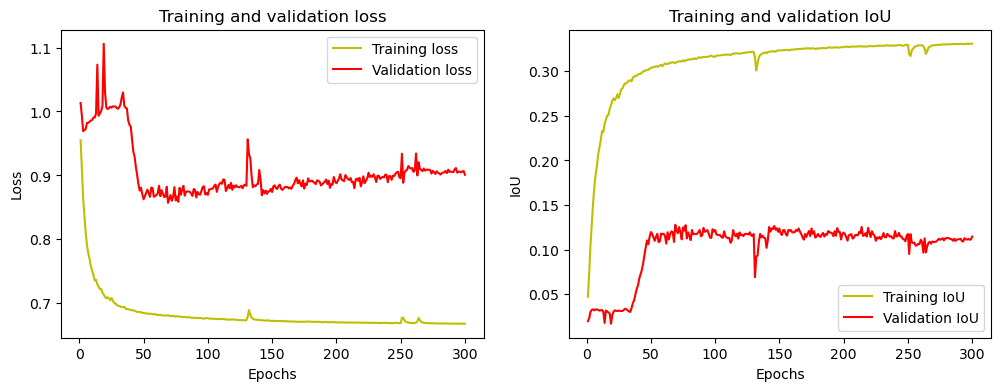

In [27]:
acc_loss_plot(history_rnet)

100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.02it/s]


Test set prediction labels length : 5
Shape of one mask label :  (1146, 872)


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 163.39it/s]


Mean IoU = 0.486


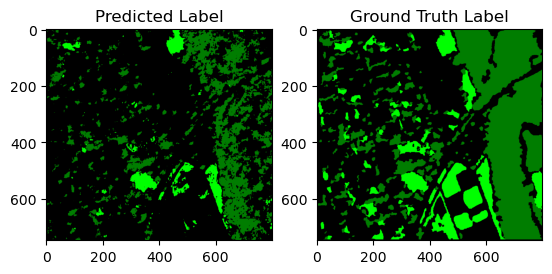

In [28]:
model_rnet = tf.keras.models.load_model(fname_rnet, compile = False)

test_pred_labels = test_pipeline(model_rnet, test_images, test_labels, BACKBONE)
test_segmented_mask_plot(test_labels, test_pred_labels)

#### Seresnet34

In [29]:
BACKBONE = 'seresnet34'
epochs = 300
fname_icv3, history_icv3 = model_train_pipeline(X_train, y_train, BACKBONE = BACKBONE, epochs = epochs)

(617, 224, 224, 3) (617, 224, 224, 3)
Model will be saved in directory :  ./model_checkpoint/
Epoch 1/300
35/35 [==============================] - ETA: 0s - loss: 0.9701 - accuracy: 0.5472 - iou_score: 0.0393
Epoch 1: iou_score improved from -inf to 0.03930, saving model to ./model_checkpoint/zurich_train_seresnet34.hdf5
35/35 [==============================] - 18s 121ms/step - loss: 0.9701 - accuracy: 0.5472 - iou_score: 0.0393 - val_loss: 1.0055 - val_accuracy: 0.3548 - val_iou_score: 0.0209
Epoch 2/300
35/35 [==============================] - ETA: 0s - loss: 0.9185 - accuracy: 0.7720 - iou_score: 0.0650
Epoch 2: iou_score improved from 0.03930 to 0.06497, saving model to ./model_checkpoint/zurich_train_seresnet34.hdf5
35/35 [==============================] - 3s 87ms/step - loss: 0.9185 - accuracy: 0.7720 - iou_score: 0.0650 - val_loss: 0.9765 - val_accuracy: 0.9031 - val_iou_score: 0.0267
Epoch 3/300
35/35 [==============================] - ETA: 0s - loss: 0.8716 - accuracy: 0.8622 

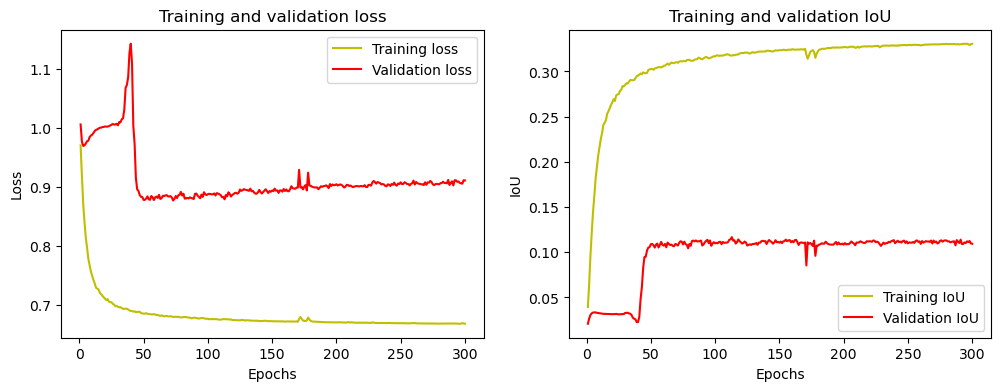

In [30]:
acc_loss_plot(history_icv3)

100%|█████████████████████████████████████████████| 5/5 [00:04<00:00,  1.17it/s]


Test set prediction labels length : 5
Shape of one mask label :  (1146, 872)


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 404.93it/s]


Mean IoU = 0.542


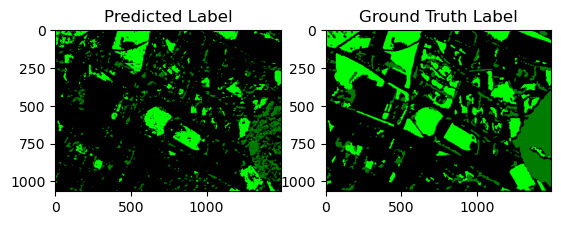

In [31]:
model_icv3 = tf.keras.models.load_model(fname_icv3, compile = False)

test_pred_labels = test_pipeline(model_icv3, test_images, test_labels, BACKBONE)
test_segmented_mask_plot(test_labels, test_pred_labels)

##### Model from scratch

In [32]:
# Define U-Net model with batch normalization
def unet_model(IMG_HEIGHT=224, IMG_WIDTH=224, IMG_CHANNELS=1, n_classes=1):
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Downsample
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = BatchNormalization()(c1)
    c1 = Dropout(0.4)(c1) 
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    c1 = BatchNormalization()(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = BatchNormalization()(c2)
    c2 = Dropout(0.3)(c2) 
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    c2 = BatchNormalization()(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = BatchNormalization()(c3)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    c3 = BatchNormalization()(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = BatchNormalization()(c4)
    c4 = Dropout(0.5)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    c4 = BatchNormalization()(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = BatchNormalization()(c5)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    c5 = BatchNormalization()(c5)
    
    # UPSample 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = BatchNormalization()(c6)
    c6 = Dropout(0.5)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
    c6 = BatchNormalization()(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = BatchNormalization()(c7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
    c7 = BatchNormalization()(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = BatchNormalization()(c8)
    c8 = Dropout(0.3)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
    c8 = BatchNormalization()(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = BatchNormalization()(c9)
    c9 = Dropout(0.4)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
    c9 = BatchNormalization()(c9)
     
    outputs = Conv2D(n_classes, (1, 1), activation='softmax')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [33]:
IMG_HEIGHT = X_train.shape[1]
IMG_WIDTH  = X_train.shape[2]
IMG_CHANNELS = X_train.shape[3]

n_classes = y_train.shape[3]

model = unet_model(IMG_HEIGHT=IMG_HEIGHT , IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS, n_classes=n_classes)

#Define loss, metrics and optimizer to be used for training
class_weights = [0.1,0.5,0.4]
dice_loss = sm.losses.DiceLoss(class_weights=class_weights) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)  

metrics = ['accuracy', sm.metrics.IOUScore(class_weights=class_weights)]

lr = 0.001
optim = keras.optimizers.Adam(lr)

model.compile(optimizer=optim, loss= total_loss, metrics=metrics)

In [34]:
model_checkpoint_folder = './model_checkpoint/'
os.makedirs(model_checkpoint_folder, exist_ok = True)

filename = f'zurich_train_scratch.hdf5'
print('Model will be saved in directory : ', model_checkpoint_folder)
fname_scratch = os.path.join(model_checkpoint_folder, filename)

# Set callback functions to early stop training and save the best model so far
callbacks = [ModelCheckpoint(filepath = fname_scratch, monitor = 'iou_score', mode='max', save_best_only = True, verbose = 1)]#,lrate_scheduler                         


history_scratch = model.fit(X_train, y_train, 
                    batch_size = 16,
                    validation_split=0.2,
                    verbose=1, 
                    epochs=300, 
                    shuffle=True,
                   callbacks = callbacks)

Model will be saved in directory :  ./model_checkpoint/
Epoch 1/300


2024-03-03 13:45:10.397369: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape inmodel_4/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


31/31 [==============================] - ETA: 0s - loss: 0.9741 - accuracy: 0.5070 - iou_score: 0.0482
Epoch 1: iou_score improved from -inf to 0.04820, saving model to ./model_checkpoint/zurich_train_scratch.hdf5
31/31 [==============================] - 16s 232ms/step - loss: 0.9741 - accuracy: 0.5070 - iou_score: 0.0482 - val_loss: 0.9731 - val_accuracy: 0.9160 - val_iou_score: 0.0281
Epoch 2/300
30/31 [============================>.] - ETA: 0s - loss: 0.9177 - accuracy: 0.7333 - iou_score: 0.0769
Epoch 2: iou_score improved from 0.04820 to 0.07779, saving model to ./model_checkpoint/zurich_train_scratch.hdf5
31/31 [==============================] - 2s 61ms/step - loss: 0.9165 - accuracy: 0.7346 - iou_score: 0.0778 - val_loss: 0.9713 - val_accuracy: 0.8621 - val_iou_score: 0.0303
Epoch 3/300
30/31 [============================>.] - ETA: 0s - loss: 0.8882 - accuracy: 0.8050 - iou_score: 0.0969
Epoch 3: iou_score improved from 0.07779 to 0.09706, saving model to ./model_checkpoint/zuri

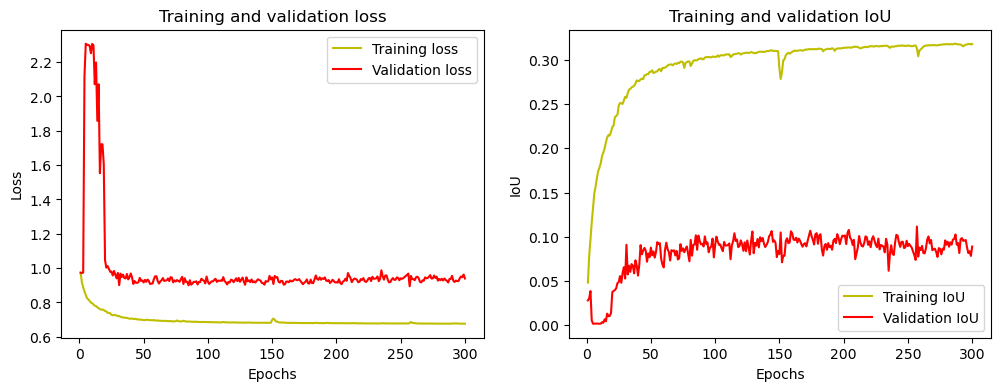

In [35]:
acc_loss_plot(history_scratch)

100%|█████████████████████████████████████████████| 5/5 [00:03<00:00,  1.32it/s]


Test set prediction labels length : 5
Shape of one mask label :  (1146, 872)


100%|████████████████████████████████████████████| 5/5 [00:00<00:00, 392.45it/s]


Mean IoU = 0.532


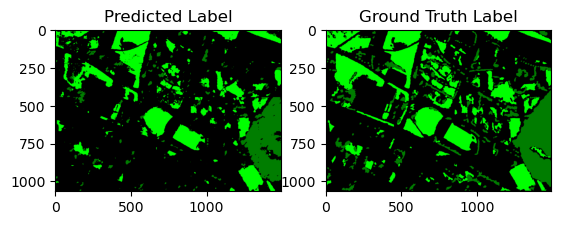

In [36]:
model_scratch = tf.keras.models.load_model(fname_scratch, compile = False)
BACKBONE = None
test_pred_labels = test_pipeline(model_scratch, test_images, test_labels, BACKBONE)
test_segmented_mask_plot(test_labels, test_pred_labels)

## 2.


In [10]:
from PIL import Image
import numpy as np

In [11]:
def load_data_delhi(images_dir:str, groundtruth_dir:str, image_range: list):
    images = []
    masks = []

    for image_id in range(image_range[0], image_range[1]+1):
        # Load image
        img_path = images_dir + f"image{image_id}.jpg"
        image = Image.open(img_path) # RGB image
        img = np.array(image) # shape (X, Y, channels)
        
        # scale img to 0-1 range; normalizing each channels independently
        scaler = MinMaxScaler()
        num_channels = img.shape[-1]
        img = scaler.fit_transform(img.reshape(-1, num_channels)).reshape(img.shape) # each column represent a band
        
        
        # Load mask
        mask_path = groundtruth_dir + f"image{image_id}_gt.png"
        mask = Image.open(mask_path) # RGB mask
        mask = np.array(mask) # shape (X, Y, channels)

        images.append(img)
        masks.append(mask)
        
    print(f"Images count: {len(images)} & Masks count: {len(masks)}")
    print('Images are Normalized and Masks are not !')

    print()
    print('Each Image & its corresponding mask size : ')
    # to get the shape of all images and masks
    for i,m in zip(images, masks):
        print(i.shape, m.shape)

    print()
        
    return images, masks

Images count: 20 & Masks count: 20
Images are Normalized and Masks are not !

Each Image & its corresponding mask size : 
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)
(768, 1024, 3) (768, 1024, 3)



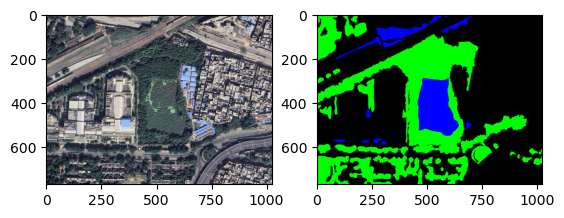

In [12]:
# dataset folder of Delhi dataset
data_dir_delhi = "./Delhi Google earth/"
images_dir_delhi = data_dir_delhi + "images/"
groundtruth_dir_delhi = data_dir_delhi + "groundtruth/"

# test set
test_images_delhi, test_masks_delhi = load_data_delhi(images_dir_delhi, groundtruth_dir_delhi, [1,20]) # 1-20 images are there
# Plot a image
plt.subplot(1, 2, 1)
plt.imshow(test_images_delhi[0][:,:,:3]) # RGB

# Plot for ground truth
plt.subplot(1, 2, 2)
plt.imshow(test_masks_delhi[0])

plt.show()

In [13]:
np.array(test_images_delhi).max(), np.array(test_images_delhi).min()

(1.0, 0.0)

In [14]:
# To find unique values of each all pixels in all images
unique_values = np.unique(np.array(test_masks_delhi).reshape(-1, 3), axis=0) # Reshape to 2D array;  find the unique rows (unique pixel values) - a pixel with 3 channels
print(len(unique_values))
print(unique_values)

3
[[  0   0   0]
 [  0   0 255]
 [  0 255   0]]


In [15]:
def rgb_to_label_delhi(image_mask):
    """
    Convert 3D- RGB label masks to 2D label masks.
    3D mask is generated from manual labelling of image pixel
    """
    # below is the RGB to integer label
    C0 = np.array([0,0,0])
    trees = np.array([0, 255, 0])   # RGB values for Trees
    grass = np.array([0, 0, 255])   # RGB values for Grass
    
    # all classes except these 2 as same class label with 0 label
    label_seg = np.zeros(image_mask.shape[:2], dtype=np.uint8)
    label_seg[np.all(image_mask == C0, axis=-1)] = 0
    label_seg[np.all(image_mask == trees, axis=-1)] = 1
    label_seg[np.all(image_mask == grass, axis=-1)] = 2
    
    return label_seg

In [16]:
class EnsemblePredictor:
    def __init__(self, fname1, fname2, fname_scratch):
        self.fname1 = fname1
        self.fname2 = fname2
        self.fname_scratch = fname_scratch
        self.model1 = tf.keras.models.load_model(fname1, compile=False)
        self.model2 = tf.keras.models.load_model(fname2, compile=False)
        self.model3 = tf.keras.models.load_model(fname_scratch, compile=False)
        self.BACKBONE1 = 'resnet34'
        self.BACKBONE2 = 'seresnet34'
        self.preprocess_input1 = sm.get_preprocessing(self.BACKBONE1)
        self.preprocess_input2 = sm.get_preprocessing(self.BACKBONE2)

    def predict(self, input_image):
        input_image = np.expand_dims(input_image, 0)  # to shape (1, height, width, channels)

        processed_input1 = self.preprocess_input1(input_image)
        processed_input2 = self.preprocess_input2(input_image)

        pred1 = self.model1.predict(processed_input1, verbose=0)
        pred2 = self.model2.predict(processed_input2, verbose=0)
        pred3 = self.model3.predict(input_image, verbose=0)

        final_prediction = pred1 + pred2 + pred3

        return final_prediction

In [17]:
def test_prediction_delhi(fname1, fname2, fname_scratch, images:list, patch_size=(224, 224)): 
    pred_labels = []

    ensemble_predictor = EnsemblePredictor(fname1, fname2, fname_scratch) # model initialisation
    
    for i in tqdm(range(len(images))):
        img = images[i] # each image is of size (height, width, channels)
        label_seg = np.zeros((img.shape[0], img.shape[1]), dtype=np.uint8)
        height, width, _ = img.shape
        
        if height % patch_size[0] == 0: # say height = 448 and patch_size = (224,224)
            height_pixels = [i for i in range(0, height - patch_size[0] + 1, patch_size[0])] # then = [0, 224]

        else: # say height = 449
            height_pixels = [i for i in range(0, height + 1, patch_size[0])] # then = [0, 224, 448]


        if width % patch_size[1] == 0: # slly
            width_pixels = [i for i in range(0, width - patch_size[1] + 1, patch_size[1])]

        else: # say height = 449
            width_pixels = [i for i in range(0, width + 1, patch_size[1])]
            

        for y in height_pixels:
            for x in width_pixels:
                x1 = x
                y1 = y

                y2 = y1 + patch_size[0]
                x2 = x1 + patch_size[1]

                if width % patch_size[1] != 0 and x == width_pixels[-1]: # if not multiple of patch size & x is the last element
                    # then take patch from last-patch_size to last pixel
                    x1 = width - patch_size[1]
                    x2 = width

                    width_rem = width - x # difference between last pixel in image and last element in width_pixels

                if height % patch_size[0] != 0 and y == height_pixels[-1]: # if not multiple of patch size& y is the last element
                    # then take patch from last-patch_size to last pixel
                    y1 = height - patch_size[0]
                    y2 = height

                    height_rem = height - y # slly


                image_patch = img[y1:y2, x1:x2, :]

                y_pred = ensemble_predictor.predict(image_patch) # shape (1, height, width, num_classes)
                y_pred_argmax = np.argmax(y_pred, axis=3) # max. value along the channels dimen. shape (1, height, width)

                x1p = 0
                y1p = 0
                if width % patch_size[1] != 0 and x == width_pixels[-1]:
                    x1p = -width_rem

                if height % patch_size[0] != 0 and y == height_pixels[-1]:
                    y1p = - height_rem


                label_seg[y:y + patch_size[0], x:x + patch_size[1]] = y_pred_argmax[0,y1p:,x1p:] # removing num_images dimension

        pred_labels.append(label_seg)

    return pred_labels

In [18]:
# for test set prediction and calc. test set prediction performance
def test_pipeline_delhi(fname1, fname2, fname_scratch, test_images, test_labels):
    # test set prediction: this will have class label number
    patch_size = (224, 224)

    # Input images has to be a list with each image having shape : (height, width, channels)
    test_pred_labels = test_prediction_delhi(fname1, fname2, fname_scratch, test_images, patch_size)
    print("Test set prediction labels length :", len(test_pred_labels))
    print('Shape of one mask label : ', test_pred_labels[0].shape)

    # Calculate IOU score on test set
    n_classes = 3 # from trained model

    iou_metric = MeanIoU(num_classes=n_classes)

    for i in tqdm(range(len(test_pred_labels))):  
        iou_metric.update_state(test_labels[i], test_pred_labels[i])

    print("Mean IoU =", round(iou_metric.result().numpy(), 3))

    return test_pred_labels

In [19]:
# Test labels original
# Converting rgb to class label
test_labels = []
for i in tqdm(range(len(test_masks_delhi))):
    label = rgb_to_label_delhi(test_masks_delhi[i])
    test_labels.append(label)
    
print("No. of test masks :", len(test_labels))
print('Shape of one mask label : ', test_labels[0].shape)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 34.88it/s]

No. of test masks : 20
Shape of one mask label :  (768, 1024)


In [20]:
fname_rnet = './model_checkpoint/zurich_train_resnet34.hdf5'
fname_icv3 = './model_checkpoint/zurich_train_seresnet34.hdf5'
fname_scratch = './model_checkpoint/zurich_train_scratch.hdf5'

test_pred_labels = test_pipeline_delhi(fname_rnet, fname_icv3, fname_scratch, test_images_delhi, test_labels) # NOTE: fname_ is in order as order of model is in func. ensemble_predict 

2024-03-03 17:20:12.909439: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-03 17:20:12.928025: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-03-03 17:20:12.928130: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

Test set prediction labels length : 20
Shape of one mask label :  (768, 1024)


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [00:00<00:00, 284.78it/s]

Mean IoU = 0.153


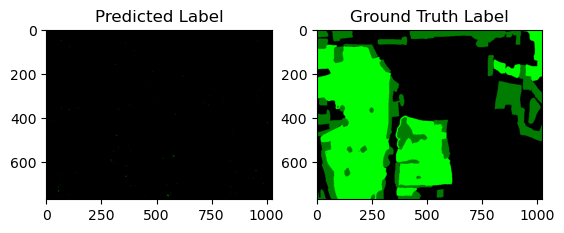

In [21]:
test_segmented_mask_plot(test_labels, test_pred_labels)